# Predictions

## Data wrangling

In [1]:
# Preamble
import pandas as pd
import numpy as np
pd.set_option("mode.chained_assignment", None)
import random
random.seed(1509)
import matplotlib.pyplot as plt
import lightgbm as lgb
import pyarrow.feather as feather
from os import chdir, getcwd
import statsmodels.api as sm
from pprint import pprint
from nested_cv import NestedCV

# sci-kit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn import tree

In [2]:
data_dir = '/home/jovyan/work/Data/'
results_dir = '/home/jovyan/work/Results/'

In [3]:
# select_features = ['reporter.ISO', 'partner.ISO', 'year',
#                    'ln.Tot_IFF_t', 'ln.In_Tot_IFF_t',
#                    'ln.gdp_o', 'ln.gdp_d', 'ln.pop_o', 'ln.pop_d', 
#                    'dist', 'contig', 
#                    'comlang', 'comcol', 'col45', 
#                    'ihs.entry_cost_o', 'ihs.entry_cost_d', 'rta',
#                    'rCorrCont', 'pCorrCont',
#                    'rRegQual', 'pRegQual', 
#                    'rRuleLaw', 'pRuleLaw',
#                    'rSecrecyScore', 'pSecrecyScore',
#                    'rFSI.rank', 'pFSI.rank',
#                    'rKFSI13', 'pKFSI13',
#                    'rKFSI17', 'pKFSI17',
#                    'rKFSI20', 'pKFSI20',
#                    'rFATF', 'pFATF',
#                    'ihs.tariff',
#                    'kai_o', 'kai_d', 'kao_o', 'kao_d',
#                    'cc_o', 'cc_d', 'cci_o', 'cci_d', 'cco_o', 'cco_d',
#                    'di_o', 'di_d', 'dii_o', 'dii_d', 'dio_o', 'dio_d']
select_features = ['reporter.ISO', 'partner.ISO', 'year',
                   'ln.Tot_IFF_t', 'ln.In_Tot_IFF_t',
                   'ln.gdp_o', 'ln.gdp_d', 'ln.pop_o', 'ln.pop_d', 
                   'dist', 'contig', 
                   'comlang', 'comcol', 'col45', 
                   'ihs.entry_cost_o', 'ihs.entry_cost_d', 'rta',
                   'rCorrCont', 'pCorrCont',
                   'rRegQual', 'pRegQual', 
                   'rRuleLaw', 'pRuleLaw',
                   'pSecrecyScore',
                   'pFSI.rank',
                   'pKFSI13',
                   'pKFSI17',
                   'pKFSI20',
                   'rFATF', 'pFATF',
                   'ihs.tariff',
                   'kai_o', 'kai_d', 'kao_o', 'kao_d',
                   'cc_o', 'cc_d', 'cci_o', 'cci_d', 'cco_o', 'cco_d',
                   'di_o', 'di_d', 'dii_o', 'dii_d', 'dio_o', 'dio_d']
# features = [       'ln.gdp_o', 'ln.gdp_d', 'ln.pop_o', 'ln.pop_d', 
#                    'dist', 'contig', 
#                    'comlang', 'comcol', 'col45', 
#                    'ihs.entry_cost_o', 'ihs.entry_cost_d', 'rta',
#                    'rCorrCont', 'pCorrCont',
#                    'rRegQual', 'pRegQual', 
#                    'rRuleLaw', 'pRuleLaw',
#                    'rSecrecyScore', 'pSecrecyScore',
#                    'rFSI.rank', 'pFSI.rank',
#                    'rKFSI13', 'pKFSI13',
#                    'rKFSI17', 'pKFSI17',
#                    'rKFSI20', 'pKFSI20',
#                    'rFATF', 'pFATF',
#                    'ihs.tariff',
#                    'kai_o', 'kai_d', 'kao_o', 'kao_d',
#                    'cc_o', 'cc_d', 'cci_o', 'cci_d', 'cco_o', 'cco_d',
#                    'di_o', 'di_d', 'dii_o', 'dii_d', 'dio_o', 'dio_d']
features = [       'ln.gdp_o', 'ln.gdp_d', 'ln.pop_o', 'ln.pop_d', 
                   'dist', 'contig', 
                   'comlang', 'comcol', 'col45', 
                   'ihs.entry_cost_o', 'ihs.entry_cost_d', 'rta',
                   'rCorrCont', 'pCorrCont',
                   'rRegQual', 'pRegQual', 
                   'rRuleLaw', 'pRuleLaw',
                   'pSecrecyScore',
                   'pFSI.rank',
                   'pKFSI13',
                   'pKFSI17',
                   'pKFSI20',
                   'rFATF', 'pFATF',
                   'ihs.tariff',
                   'kai_o', 'kai_d', 'kao_o', 'kao_d',
                   'cc_o', 'cc_d', 'cci_o', 'cci_d', 'cco_o', 'cco_d',
                   'di_o', 'di_d', 'dii_o', 'dii_d', 'dio_o', 'dio_d']

## Subset from training and test samples

In [4]:
train_agg = feather.read_feather(results_dir + 'train_agg.feather')
test_agg = feather.read_feather(results_dir + 'test_agg.feather')

In [5]:
data = feather.read_feather(results_dir + 'panel_agg_trans.feather')

In [6]:
def create_smp(data, features):
    """
    Create train and test samples that are complete.
    """
    smp = data[features]
    smp.dropna(axis=0, how='any', inplace=True)
    return smp

### Train/test split

In [7]:
train_agg_smp = create_smp(train_agg, select_features)
test_agg_smp = create_smp(test_agg, select_features)

In [8]:
feather.write_feather(train_agg_smp, results_dir + 'train_agg_smp.feather')
feather.write_feather(test_agg_smp, results_dir + 'test_agg_smp.feather')

In [9]:
Y_train_out = train_agg_smp[['ln.Tot_IFF_t']]
Y_train_in = train_agg_smp[['ln.In_Tot_IFF_t']]
X_train = train_agg_smp[features]
Y_test_out = test_agg_smp[['ln.Tot_IFF_t']]
Y_test_in = test_agg_smp[['ln.In_Tot_IFF_t']]
X_test = test_agg_smp[features]

In [10]:
print('X_train: ', X_train.shape, '\nX_test: ',  X_test.shape)

X_train:  (7716, 42) 
X_test:  (1952, 42)


### Full sample for cross-validation

In [11]:
data_smp = create_smp(data, select_features)

In [12]:
# feather.write_feather(Y_train_out, results_dir + 'Y_train_out.feather')
# feather.write_feather(Y_test_out, results_dir + 'Y_test_out.feather')

In [13]:
Y_out = data_smp[['ln.Tot_IFF_t']]
Y_in = data_smp[['ln.In_Tot_IFF_t']]
X = data_smp[features]

In [14]:
print('X: ', X.shape)

X:  (9668, 42)


## Linear regression

### Fit linear regression model

In [15]:
linear_mod_out = LinearRegression()  
linear_mod_out.fit(X_train.values, Y_train_out.values)

LinearRegression()

In [16]:
linear_mod_in = LinearRegression()  
linear_mod_in.fit(X_train.values, Y_train_in.values)

LinearRegression()

### Print coefficients

In [17]:
print(linear_mod_out.intercept_)
print(linear_mod_out.coef_)

[-33.2356004]
[[ 1.16659442e+00  3.44650814e-01  1.54840248e-01  1.00601971e+00
  -2.21145026e-04  2.46779807e+00  3.34143082e-01 -3.38338632e-01
   7.22130575e-01 -2.49827837e-02  1.02921243e-01  3.09276976e-01
  -9.71637460e-03  2.00036651e-02  2.30157383e-03  2.52801379e-02
   1.92833790e-02 -1.48771795e-02  1.83009037e-02  5.80706229e-03
   3.96719534e-01 -2.79359189e+00  1.98093540e+00 -2.20491279e+00
   7.04106794e-01 -4.74850015e-01  1.41955450e-02 -1.60152637e+00
   1.54679522e+00  8.77013319e-01  7.05045363e-02 -4.96209702e-02
   2.45196187e-01 -1.68397531e-01 -1.04187114e-01  6.91555904e-02
  -2.36720712e-01  4.17839859e-02  2.25095708e-02  1.31493183e-01
  -4.95950994e-01 -4.79252114e-02]]


In [18]:
print(linear_mod_in.intercept_)
print(linear_mod_in.coef_)

[-29.9835357]
[[ 9.98498970e-01  2.41004610e-01  3.15533402e-01  9.59729009e-01
  -2.75208993e-04  1.98778146e+00  5.66579244e-01  2.78365434e-01
   1.03429765e+00 -5.95886494e-03  1.35300297e-01  3.97453835e-01
  -1.47781837e-02  3.23077568e-02  7.43558908e-03  2.86130908e-02
   2.99342719e-02 -2.38382873e-02  1.58414655e-02  2.17502554e-03
   6.16257292e-01 -1.85056815e+00  7.25817571e-01 -1.86719911e+00
   7.93799916e-01 -3.40551163e-01 -1.96570177e-01 -1.90153580e+00
   8.18480999e-01  9.63247434e-01  8.89877753e-02 -7.26324555e-02
   3.00805843e-01 -1.53668204e-01 -1.22830292e-01  8.40329253e-03
  -9.42782600e-02  4.86008969e-02 -1.66252788e-01  1.96731863e-02
  -2.23037315e-02  7.75286075e-02]]


In [19]:
# Xconst = sm.add_constant(X_train)
# est = sm.OLS(Y_train_out, Xconst)
# est2 = est.fit()
# print(est2.summary())

In [20]:
# Xconst = sm.add_constant(X_train)
# est = sm.OLS(Y_train_in, Xconst)
# est2 = est.fit()
# print(est2.summary())

### Predictions

In [21]:
preds_LM_train_out = linear_mod_out.predict(X_train)
preds_LM_test_out = linear_mod_out.predict(X_test)

In [22]:
preds_LM_train_in = linear_mod_in.predict(X_train)
preds_LM_test_in = linear_mod_in.predict(X_test)

In [23]:
feather.write_feather(pd.DataFrame(preds_LM_train_out), results_dir + 'preds.LM.train_out_agg.feather')
feather.write_feather(pd.DataFrame(preds_LM_test_out), results_dir + 'preds.LM.test_out_agg.feather')

In [24]:
feather.write_feather(pd.DataFrame(preds_LM_train_in), results_dir + 'preds.LM.train_in_agg.feather')
feather.write_feather(pd.DataFrame(preds_LM_test_in), results_dir + 'preds.LM.test_in_agg.feather')

### Predictive accuracy

In [25]:
print("RMSE of the training set (outflows):", np.sqrt(mean_squared_error(Y_train_out, preds_LM_train_out)))
print("R^2 of the training set (outflows):", r2_score(Y_train_out, preds_LM_train_out))
print("RMSE of the test set (outflows):", np.sqrt(mean_squared_error(Y_test_out, preds_LM_test_out)))
print("R^2 of the test set (outflows):", r2_score(Y_test_out, preds_LM_test_out))

RMSE of the training set (outflows): 2.1109733849985695
R^2 of the training set (outflows): 0.5740721055779541
RMSE of the test set (outflows): 2.1263494580803624
R^2 of the test set (outflows): 0.5663310869938217


In [26]:
print("RMSE of the training set (inflows):", np.sqrt(mean_squared_error(Y_train_in, preds_LM_train_in)))
print("R^2 of the training set (inflows):", r2_score(Y_train_in, preds_LM_train_in))
print("RMSE of the test set (inflows):", np.sqrt(mean_squared_error(Y_test_in, preds_LM_test_in)))
print("R^2 of the test set (inflows):", r2_score(Y_test_in, preds_LM_test_in))

RMSE of the training set (inflows): 2.154808997564144
R^2 of the training set (inflows): 0.5553383401662982
RMSE of the test set (inflows): 2.1201835586940128
R^2 of the test set (inflows): 0.5643481351894684


In [27]:
print('Mean Absolute Error (outflows):', metrics.mean_absolute_error(Y_test_out, preds_LM_test_out))  
print('Mean Squared Error of the training set (outflows):', mean_squared_error(Y_train_out, preds_LM_train_out))
print('Mean Squared Error of the test set (outflows):', mean_squared_error(Y_test_out, preds_LM_test_out))
print('Dollar RMSE of the training set (outflows):', np.mean(np.square((np.exp(Y_train_out.values)*10**3 - np.exp(preds_LM_train_out)*10**3))) / 10**9)
print('Dollar RMSE of the test set (outflows):', np.mean(np.square((np.exp(Y_test_out.values)*10**3 - np.exp(preds_LM_test_out)*10**3))) / 10**6)

Mean Absolute Error (outflows): 1.5517737574345303
Mean Squared Error of the training set (outflows): 4.456208632172319
Mean Squared Error of the test set (outflows): 4.52136201787865
Dollar RMSE of the training set (outflows): 3674423795.036064
Dollar RMSE of the test set (outflows): 2875209529427.054


In [28]:
print('Mean Absolute Error (inflows):', metrics.mean_absolute_error(Y_test_in, preds_LM_test_in))
print('Mean Squared Error of the training set (inflows):', mean_squared_error(Y_train_in, preds_LM_train_in))
print('Mean Squared Error of the test set (inflows):', mean_squared_error(Y_test_in, preds_LM_test_in))
print('Dollar RMSE of the test set (inflows):', np.mean(np.square((np.exp(Y_train_in.values)*10**3 - np.exp(preds_LM_train_in)*10**3))) / 10**9)
print('Dollar RMSE of the test set (inflows):', np.mean(np.square((np.exp(Y_test_in.values)*10**3 - np.exp(preds_LM_test_in)*10**3))) / 10**9)

Mean Absolute Error (inflows): 1.5825367902792842
Mean Squared Error of the training set (inflows): 4.6432018159833905
Mean Squared Error of the test set (inflows): 4.4951783225564075
Dollar RMSE of the test set (inflows): 1203745624.8837152
Dollar RMSE of the test set (inflows): 1651564047.794827


### Cross-validation

In [29]:
linear_mod_out = LinearRegression()  
linear_mod_out.fit(X.values, Y_out.values)

LinearRegression()

In [30]:
scores = cross_val_score(linear_mod_out, X, Y_out.values.ravel(), cv = 6)
print('Cross-validated scores:', scores)

Cross-validated scores: [0.45807479 0.30130499 0.51707985 0.46344754 0.45227464 0.12578676]


In [31]:
predictions = cross_val_predict(linear_mod_out, X, Y_out.values.ravel(), cv = 6)
r2_score(Y_out, predictions)

0.462132437575033

## Random Forests

### Fit baseline random forests regression

In [51]:
RF_0_mod_out = RandomForestRegressor(random_state = 1509)
RF_0_mod_out.fit(X, Y_out.values.ravel())

RandomForestRegressor(random_state=1509)

In [33]:
RF_0_mod_in = RandomForestRegressor(random_state = 1509)
RF_0_mod_in.fit(X_train, Y_train_in.values.ravel())

RandomForestRegressor(random_state=1509)

### Tune hyperparameters with randomized search

In [52]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 3000, num = 100)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 500, num = 100)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(2, 50, num = 10)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 100, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 40, 70, 100, 130, 161, 191, 221, 251, 281, 312, 342, 372, 402, 432, 463, 493, 523, 553, 583, 614, 644, 674, 704, 734, 765, 795, 825, 855, 885, 916, 946, 976, 1006, 1036, 1067, 1097, 1127, 1157, 1187, 1218, 1248, 1278, 1308, 1338, 1369, 1399, 1429, 1459, 1489, 1520, 1550, 1580, 1610, 1640, 1671, 1701, 1731, 1761, 1791, 1822, 1852, 1882, 1912, 1942, 1973, 2003, 2033, 2063, 2093, 2124, 2154, 2184, 2214, 2244, 2275, 2305, 2335, 2365, 2395, 2426, 2456, 2486, 2516, 2546, 2577, 2607, 2637, 2667, 2697, 2728, 2758, 2788, 2818, 2848, 2879, 2909, 2939, 2969, 3000], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425

In [53]:
# Create the base model to tune
RF_0_mod_out = RandomForestRegressor(random_state = 1509)

# Random search of parameters on base model using 3 fold cross validation 
# Search across 100 different combinations, and use all available cores
RF_random_out = RandomizedSearchCV(random_state = 1509,
                                   estimator = RF_0_mod_out, 
                                   param_distributions = random_grid,
                                   scoring = 'r2',
                                   n_iter = 100, cv = 3, 
                                   verbose = 3, n_jobs = -1)

In [54]:
# Fit the random search model
RF_random_out.fit(X, Y_out.values.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END bootstrap=True, max_depth=475, max_features=sqrt, min_samples_leaf=45, min_samples_split=12, n_estimators=372;, score=0.228 total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=475, max_features=sqrt, min_samples_leaf=45, min_samples_split=12, n_estimators=372;, score=0.344 total time=   3.8s
[CV 2/3] END bootstrap=True, max_depth=195, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=1278;, score=0.214 total time= 1.9min
[CV 1/3] END bootstrap=False, max_depth=430, max_features=auto, min_samples_leaf=78, min_samples_split=2, n_estimators=2093;, score=0.221 total time= 2.5min
[CV 3/3] END bootstrap=False, max_depth=430, max_features=auto, min_samples_leaf=78, min_samples_split=2, n_estimators=2093;, score=0.413 total time= 2.3min
[CV 2/3] END bootstrap=False, max_depth=290, max_features=sqrt, min_samples_leaf=78, min_samples_split=50, n_estimators=2728;, score=0.486 total time=  35.

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1509),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, 55, 60, 65,
                                                      70, 75, 80, 85, 90, 95,
                                                      100, 105, 110, 115, 120,
                                                      125, 130, 135, 140, 145,
                                                      150, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 12, 23, 34, 45,
                                                             56, 67, 78, 89,
                                                             100],
                                        'min_samples_sp

[CV 1/3] END bootstrap=True, max_depth=390, max_features=auto, min_samples_leaf=56, min_samples_split=44, n_estimators=1912;, score=0.377 total time= 1.5min
[CV 3/3] END bootstrap=True, max_depth=390, max_features=auto, min_samples_leaf=56, min_samples_split=44, n_estimators=1912;, score=0.443 total time= 1.4min
[CV 2/3] END bootstrap=True, max_depth=350, max_features=auto, min_samples_leaf=23, min_samples_split=50, n_estimators=1127;, score=0.406 total time= 1.1min
[CV 1/3] END bootstrap=True, max_depth=395, max_features=auto, min_samples_leaf=89, min_samples_split=50, n_estimators=2003;, score=0.365 total time= 1.4min
[CV 3/3] END bootstrap=True, max_depth=395, max_features=auto, min_samples_leaf=89, min_samples_split=50, n_estimators=2003;, score=0.403 total time= 1.3min
[CV 2/3] END bootstrap=False, max_depth=155, max_features=auto, min_samples_leaf=1, min_samples_split=18, n_estimators=1822;, score=-0.510 total time= 4.0min
[CV 1/3] END bootstrap=True, max_depth=70, max_features=s

In [92]:
print('Best Score: %s' % RF_random_out.best_score_)

Best Score: 0.42809867095426846


In [56]:
RF_random_out.best_params_

{'n_estimators': 1278,
 'min_samples_split': 23,
 'min_samples_leaf': 23,
 'max_features': 'auto',
 'max_depth': 125,
 'bootstrap': True}

In [ ]:
RF_random_out.cv_results_

In [91]:
best_random = RF_random_out.best_estimator_
print(best_random.score(X, Y_out))
print(best_random.score(X_train , Y_train_out))
print(best_random.score(X_test , Y_test_out))

0.7514533672429826
0.7524911214616127
0.7473368933288582


### Tune hyperparameters with grid search

In [62]:
# Create the base model to tune (with some parameters from random search)
RF_base_mod_out  = RandomForestRegressor(random_state = 1509,
                                         max_features = 'auto',
                                         bootstrap = True)

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [500, 2500],
    'max_depth': [10, 300],
    'min_samples_split': [8, 80],
    'min_samples_leaf': [8, 80],
}

# Grid search of parameters on base model using 3 fold cross validation 
# Search all possible cominations, and use all available cores
RF_grid_out = GridSearchCV(estimator = RF_base_mod_out, 
                           param_grid = param_grid,
                           scoring = 'r2',
                           cv = 3, 
                           verbose = 3, n_jobs = -1)

In [63]:
# Fit the grid search model
RF_grid_out.fit(X, Y_out.values.ravel())

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1509),
             n_jobs=-1,
             param_grid={'max_depth': [10, 300], 'min_samples_leaf': [8, 80],
                         'min_samples_split': [8, 80],
                         'n_estimators': [500, 2500]},
             scoring='r2', verbose=3)

[CV 2/3] END max_depth=10, min_samples_leaf=8, min_samples_split=8, n_estimators=500;, score=0.310 total time=  33.7s
[CV 1/3] END max_depth=10, min_samples_leaf=8, min_samples_split=8, n_estimators=2500;, score=0.367 total time= 2.8min
[CV 3/3] END max_depth=10, min_samples_leaf=8, min_samples_split=8, n_estimators=2500;, score=0.506 total time= 2.7min
[CV 2/3] END max_depth=10, min_samples_leaf=8, min_samples_split=80, n_estimators=2500;, score=0.342 total time= 2.3min
[CV 1/3] END max_depth=10, min_samples_leaf=80, min_samples_split=8, n_estimators=500;, score=0.366 total time=  21.0s
[CV 2/3] END max_depth=10, min_samples_leaf=80, min_samples_split=8, n_estimators=500;, score=0.428 total time=  21.0s
[CV 3/3] END max_depth=10, min_samples_leaf=80, min_samples_split=8, n_estimators=500;, score=0.413 total time=  20.2s
[CV 1/3] END max_depth=10, min_samples_leaf=80, min_samples_split=8, n_estimators=2500;, score=0.367 total time= 1.8min
[CV 3/3] END max_depth=10, min_samples_leaf=80,

In [64]:
print('Best Score: %s' % RF_grid_out.best_score_)

Best Score: 0.4029395538065928


In [65]:
RF_grid_out.best_params_

{'max_depth': 300,
 'min_samples_leaf': 8,
 'min_samples_split': 80,
 'n_estimators': 500}

In [66]:
best_grid = RF_grid_out.best_estimator_
print(best_grid.score(X_train, Y_train_out))
print(best_grid.score(X_test, Y_test_out))

0.7391362919649886
0.7340232720416157


### Manually configure hyperparameters

In [70]:
RF_mod_out = RandomForestRegressor(random_state = 1509,
                                   n_estimators = 1278,
                                   max_depth = 125,
                                   min_samples_split = 23,
                                   min_samples_leaf = 23,
                                   max_features = 'auto',
                                   bootstrap = True)

In [71]:
# Fit the manually configured model
RF_mod_out.fit(X_train, Y_train_out.values.ravel())

RandomForestRegressor(max_depth=125, min_samples_leaf=23, min_samples_split=23,
                      n_estimators=1278, random_state=1509)

In [72]:
print(RF_mod_out.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 125, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 23, 'min_samples_split': 23, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1278, 'n_jobs': None, 'oob_score': False, 'random_state': 1509, 'verbose': 0, 'warm_start': False}


### Predictions

In [37]:
# Base model
# preds_RF_train_out = RF_0.predict(X_train)
# preds_RF_test_out = RF_0.predict(X_test)

In [95]:
# Manually configured model (outflows)
preds_RF_train_out = RF_mod_out.predict(X_train)
preds_RF_test_out = RF_mod_out.predict(X_test)

In [97]:
# Model tuned with randomized and grid search (outflows)
preds_RF_train_out = RF_grid_out.predict(X_train)
preds_RF_test_out = RF_grid_out.predict(X_test)

In [ ]:
# Manually configured model (inflows)
preds_RF_train_in = RF_mod_in.predict(X_train)
preds_RF_test_in = RF_mod_in.predict(X_test)

In [76]:
feather.write_feather(pd.DataFrame(preds_RF_train_out), results_dir + 'preds.RF.train_out_agg.feather')
feather.write_feather(pd.DataFrame(preds_RF_test_out), results_dir + 'preds.RF.test_out_agg.feather')

In [ ]:
feather.write_feather(pd.DataFrame(preds_RF_train_in), results_dir + 'preds.RF.train_in_agg.feather')
feather.write_feather(pd.DataFrame(preds_RF_test_in), results_dir + 'preds.RF.test_in_agg.feather')

### Predictive accuracy

In [98]:
print("RMSE of the training set (outflows):", np.sqrt(mean_squared_error(Y_train_out, preds_RF_train_out)))
print("R^2 of the training set (outflows):", r2_score(Y_train_out, preds_RF_train_out))
print("RMSE of the test set (outflows):", np.sqrt(mean_squared_error(Y_test_out, preds_RF_test_out)))
print("R^2 of the test set (outflows):", r2_score(Y_test_out, preds_RF_test_out))

RMSE of the training set (outflows): 1.652043763142104
R^2 of the training set (outflows): 0.7391362919649886
RMSE of the test set (outflows): 1.665241841617969
R^2 of the test set (outflows): 0.7340232720416157


In [ ]:
print("RMSE of the training set (inflows):", np.sqrt(mean_squared_error(Y_train_in, preds_RF_train_in)))
print("R^2 of the training set (inflows):", r2_score(Y_train_in, preds_RF_train_in))
print("RMSE of the test set (inflows):", np.sqrt(mean_squared_error(Y_test_in, preds_RF_test_in)))
print("R^2 of the test set (inflows):", r2_score(Y_test_in, preds_RF_test_in))

In [78]:
print('Mean Absolute Error (outflows):', metrics.mean_absolute_error(Y_test_out, preds_RF_test_out))
print('Mean Squared Error of the training set (outflows):', mean_squared_error(Y_train_out, preds_RF_train_out))
print('Mean Squared Error of the test set (outflows):', mean_squared_error(Y_test_out, preds_RF_test_out))
# print('Dollar RMSE of the training set (outflows):', np.mean(np.square((np.exp(Y_train_out.values) - np.exp(preds_RF_train_out)))))
# print('Dollar RMSE of the test set (outflows):', np.mean(np.square((np.exp(Y_test_out.values) - np.exp(preds_RF_test_out)))))

Mean Absolute Error (outflows): 1.1750357264395102
Mean Squared Error of the training set (outflows): 2.7292485953367245
Mean Squared Error of the test set (outflows): 2.773030391075205


In [ ]:
print('Mean Absolute Error (inflows):', metrics.mean_absolute_error(Y_test_in, preds_RF_test_in))  
print('Mean Squared Error of the training set (inflows):', mean_squared_error(Y_train_in, preds_RF_train_in))
print('Mean Squared Error of the test set (inflows):', mean_squared_error(Y_test_in, preds_RF_test_in))
#print('Dollar RMSE of the training set (inflows):', np.mean(np.square(np.exp(Y_train_in.values)/10**3 - np.exp(preds_RF_train_in)/10**3)))
#print('Dollar RMSE of the test set (inflows):', np.mean(np.square(np.exp(Y_test_in.values)/10**3 - np.exp(preds_RF_test_in)/10**3)))

### Cross-validation

In [67]:
RF_mod_CV = RandomForestRegressor(random_state = 1509,
                                  n_estimators = 1278,
                                  max_depth = 125,
                                  min_samples_split = 23,
                                  min_samples_leaf = 23,
                                  max_features = 'auto',
                                  bootstrap = True)

In [69]:
scores = cross_val_score(RF_mod_CV, X, Y_out.values.ravel(), cv = 6)
print('Cross-validated scores:', scores)

Cross-validated scores: [0.47272326 0.48149061 0.33351371 0.43778015 0.52023699 0.24338979]


In [50]:
predictions = cross_val_predict(RF_mod_CV, X_train, Y_train_out.values.ravel(), cv = 6)
r2_score(Y_train_out, predictions)

0.7174854884929412

In [90]:
predictions = cross_val_predict(RF_mod_CV, X, Y_out.values.ravel(), cv = 6)
r2_score(Y_out, predictions)

0.494455408385449

### Visualize results

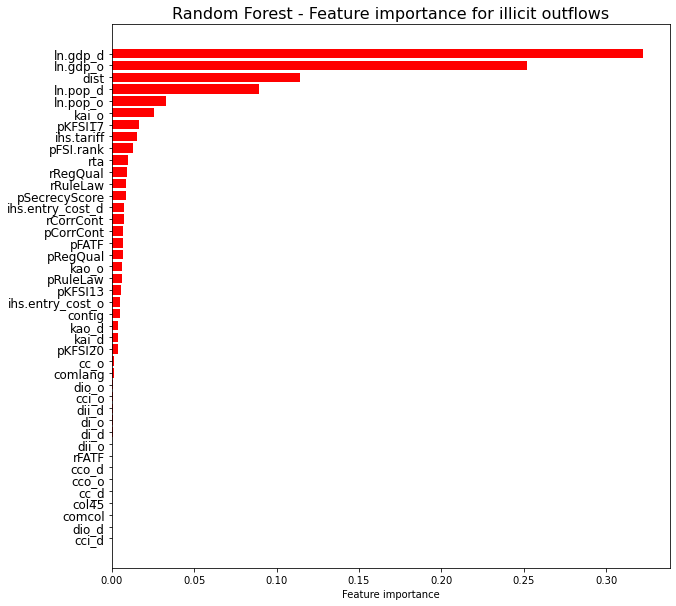

In [79]:
feat_importances = pd.Series(RF_mod_out.feature_importances_, index=X_train.columns)
indices = np.argsort(-1*feat_importances)
names = [X_train.columns[i] for i in indices]
fig, ax = plt.subplots(figsize = (10, 10))
plt.barh(range(X_train.shape[1]), feat_importances[indices], color = 'red')
plt.yticks(range(X_train.shape[1]), names, fontsize = 12)
plt.gca().invert_yaxis()
ax.set_xlabel('Feature importance')
plt.title("Random Forest - Feature importance for illicit outflows", fontsize = 16)
plt.savefig(results_dir + 'RF_feature_importance_out.png')

In [ ]:
feat_importances = pd.Series(RF_mod_in.feature_importances_, index=X_train.columns)
indices = np.argsort(-1*feat_importances)
names = [X_train.columns[i] for i in indices]
fig, ax = plt.subplots(figsize = (10, 10))
plt.barh(range(X_train.shape[1]), feat_importances[indices], color = 'red')
plt.yticks(range(X_train.shape[1]), names, fontsize = 12)
plt.gca().invert_yaxis()
ax.set_xlabel('Feature importance')
plt.title("Random Forest - Feature importance for illicit inflows", fontsize = 16)
plt.savefig(results_dir + 'RF_feature_importance_in.png')

In [ ]:
tree.export_graphviz(RF_mod_out.estimators_[0])

In [ ]:
tree.plot_tree(RF_mod_out.estimators_[0])

### Nested cross-validation

In [81]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 3000, num = 100)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 500, num = 100)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(2, 50, num = 10)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 100, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the parameter grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'bootstrap': bootstrap}

In [85]:
# Perform nested cross-validation
RF_mod_NCV = NestedCV(model = RandomForestRegressor(random_state = 1509), 
                      params_grid = param_grid,
                      outer_kfolds = 5, inner_kfolds = 5,
#                       n_jobs = -1,
                      cv_options={'metric': r2_score,
                                  'randomized_search': True,
                                  'randomized_search_iter': 10})

In [86]:
# Fit the nested cross-validated model
RF_mod_NCV.fit(X = X, y = Y_out.values.ravel())

In [87]:
RF_mod_NCV.outer_scores

[0.5284918786914943,
 0.4793250606757904,
 0.5299589394875213,
 0.5170968213306054,
 0.5090585872718156]

In [88]:
np.mean(RF_mod_NCV.outer_scores)

0.5127862574914455

In [89]:
RF_mod_NCV.best_params

{'n_estimators': [2848, 1369, 281, 463, 2909],
 'min_samples_split': [34, 7],
 'min_samples_leaf': [89, 1, 100],
 'max_features': ['sqrt', 'auto'],
 'max_depth': [490, 190, 285, 395],
 'bootstrap': [True, False]}

## Light GBM

In [ ]:
lightGBM_train_out = lgb.Dataset(X_train, Y_train_out)
lightGBM_test_out = lgb.Dataset(X_test, Y_test_out)
lightGBM_train_in = lgb.Dataset(X_train, Y_train_in)
lightGBM_test_in = lgb.Dataset(X_test, Y_test_in)

In [ ]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 100,
    'max_depth': 10,
    'learning_rate' : 0.1,
    'feature_fraction' : 0.6,
    'verbosity' : -1,
    'random_state' : 1509
}
lightGBM_mod_out = lgb.train(
    params,
    lightGBM_train_out,
    500,
    valid_sets = [lightGBM_train_out, lightGBM_test_out],
    valid_names = ["train", "test"],
    early_stopping_rounds = 50,
    verbose_eval = 500
)

In [ ]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 100,
    'max_depth': 10,
    'learning_rate' : 0.1,
    'feature_fraction' : 0.6,
    'verbosity' : -1,
    'random_state' : 1509
}
lightGBM_mod_in = lgb.train(
    params,
    lightGBM_train_in,
    500,
    valid_sets = [lightGBM_train_in, lightGBM_test_in],
    valid_names = ["train", "test"],
    early_stopping_rounds = 50,
    verbose_eval = 500
)

In [ ]:
preds_lightGBM_train_out = pd.DataFrame(lightGBM_mod_out.predict(X_train))
preds_lightGBM_test_out = pd.DataFrame(lightGBM_mod_out.predict(X_test))

In [ ]:
preds_lightGBM_train_in = pd.DataFrame(lightGBM_mod_in.predict(X_train))
preds_lightGBM_test_in = pd.DataFrame(lightGBM_mod_in.predict(X_test))

In [ ]:
feather.write_feather(preds_lightGBM_train_out, results_dir + 'preds.lightGBM.train_out_agg.feather')
feather.write_feather(preds_lightGBM_test_out, results_dir + 'preds.lightGBM.test_out_agg.feather')

In [ ]:
feather.write_feather(preds_lightGBM_train_in, results_dir + 'preds.lightGBM.train_in_agg.feather')
feather.write_feather(preds_lightGBM_test_in, results_dir + 'preds.lightGBM.test_in_agg.feather')

In [ ]:
print("RMSE of the training set (outflows):", np.sqrt(mean_squared_error(Y_train_out, preds_lightGBM_train_out)))
print("R^2 of the training set (outflows):", r2_score(Y_train_out, preds_lightGBM_train_out))
print("RMSE of the test set (outflows):", np.sqrt(mean_squared_error(Y_test_out, preds_lightGBM_test_out)))
print("R^2 of the test set (outflows):", r2_score(Y_test_out, preds_lightGBM_test_out))

In [ ]:
print("RMSE of the training set (inflows):", np.sqrt(mean_squared_error(Y_train_in, preds_lightGBM_train_in)))
print("R^2 of the training set (inflows):", r2_score(Y_train_in, preds_lightGBM_train_in))
print("RMSE of the test set (inflows):", np.sqrt(mean_squared_error(Y_test_in, preds_lightGBM_test_in)))
print("R^2 of the test set (inflows):", r2_score(Y_test_in, preds_lightGBM_test_in))

In [ ]:
print('Mean Absolute Error (outflows):', metrics.mean_absolute_error(Y_test_out, preds_lightGBM_test_out))
print('Mean Squared Error of the training set (outflows):', mean_squared_error(Y_train_out, preds_lightGBM_train_out))
print('Mean Squared Error of the test set (outflows):', mean_squared_error(Y_test_out, preds_lightGBM_test_out))
#print('Dollar RMSE of the training set (outflows):', np.mean(np.square(np.exp(Y_train_out.values)*10**3 - np.exp(preds_lightGBM_train_out)*10**3)) / 10**6)
#print('Dollar RMSE of the test set (outflows):', np.mean(np.square(np.exp(Y_test_out.values)*10**3 - np.exp(preds_lightGBM_test_out)*10**3)) / 10**6)

In [ ]:
print('Mean Absolute Error (inflows):', metrics.mean_absolute_error(Y_test_in, preds_lightGBM_test_in))
print('Mean Squared Error of the training set (inflows):', mean_squared_error(Y_train_in, preds_lightGBM_train_in))
print('Mean Squared Error of the test set (inflows):', mean_squared_error(Y_test_in, preds_lightGBM_test_in))
#print('Dollar RMSE of the training set (inflows):', np.mean(np.square(np.exp(Y_train_in.values)/10**3 - np.exp(preds_lightGBM_train_in)/10**3)))
#print('Dollar RMSE of the test set (inflows):', np.mean(np.square(np.exp(Y_test_in.values)/10**3 - np.exp(preds_lightGBM_test_in)/10**3)))

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
lgb.plot_importance(lightGBM_mod_out, height = 0.8, ax = ax)
ax.grid(False)
plt.title("LightGBM - Feature importance for illicit outflows", fontsize = 16)
plt.savefig(results_dir + 'LightGBM_feature_importance_out.png')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
lgb.plot_importance(lightGBM_mod_in, height = 0.8, ax = ax)
ax.grid(False)
plt.title("LightGBM - Feature importance for illicit inflows", fontsize = 16)
plt.savefig(results_dir + 'LightGBM_feature_importance_in.png')

## Support Vector Machine

In [ ]:
SVM_mod = svm.SVR()
SVM_mod.fit(X_train, Y_train.values.ravel())

In [ ]:
preds_SVM_train = SVM_mod.predict(X_train)
preds_SVM_test = SVM_mod.predict(X_test)

In [ ]:
feather.write_feather(pd.DataFrame(preds_SVM_train), results_dir + 'preds.SVM.train_agg.feather')
feather.write_feather(pd.DataFrame(preds_SVM_test), results_dir + 'preds.SVM.test_agg.feather')

In [ ]:
print("RMSE of the training set:", np.sqrt(mean_squared_error(Y_train, preds_SVM_train)))
print("R^2 of the training set:", r2_score(Y_train, preds_SVM_train))

In [ ]:
print("RMSE of the test set:", np.sqrt(mean_squared_error(Y_test, preds_SVM_test)))
print("R^2 of the test set:", r2_score(Y_test, preds_SVM_test))

## Neural Networks

In [ ]:
Y_train = train_agg_smp[['Tot_IFF_t']]
X_train = train_agg_smp[features]
Y_test = test_agg_smp[['Tot_IFF_t']]
X_test = test_agg_smp[features]

In [ ]:
std_sc = StandardScaler()
NN_train = std_sc.fit_transform(X_train)
NN_test = std_sc.transform(X_test)

In [ ]:
NN_mod = MLPRegressor(hidden_layer_sizes = (10),
                      activation = "logistic",
                      random_state = 1, 
                      max_iter = 1000).fit(NN_train, Y_train.values.ravel())

In [ ]:
preds_NN_train = NN_mod.predict(NN_train)
preds_NN_test = NN_mod.predict(NN_test)

In [ ]:
feather.write_feather(pd.DataFrame(preds_NN_train), results_dir + 'preds.NN.train_agg.feather')
feather.write_feather(pd.DataFrame(preds_NN_test), results_dir + 'preds.NN.test_agg.feather')

In [ ]:
print("RMSE of the training set:", np.sqrt(mean_squared_error(Y_train, preds_NN_train)))
print("R^2 of the training set:", r2_score(Y_train, preds_NN_train))

In [ ]:
print("RMSE of the test set:", np.sqrt(mean_squared_error(Y_test, preds_NN_test)))
print("R^2 of the test set:", r2_score(Y_test, preds_NN_test))

### Tuning hyperparameters

In [ ]:
NN = MLPRegressor(max_iter = 1000)
parameter_space = {
    'hidden_layer_sizes': [(10,20)],
    'activation': ['logistic', 'relu'],
    #'solver': ['sgd', 'adam'],
    #'alpha': [0.0001, 0.05],
    #'learning_rate': ['constant','adaptive'],
}

In [ ]:
NN_mod_tuned = GridSearchCV(NN, parameter_space, n_jobs = -1, cv = 3)

In [ ]:
NN_mod_tuned.fit(NN_train, Y_train.values.ravel())

In [ ]:
print('Best parameters found:\n', NN_mod_tuned.best_params_)

In [ ]:
# All results
means = NN_mod_tuned.cv_results_['mean_test_score']
stds = NN_mod_tuned.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, NN_mod_tuned.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
preds_NN_train = NN_mod_tuned.predict(NN_train)
preds_NN_test = NN_mod_tuned.predict(NN_test)

In [ ]:
feather.write_feather(pd.DataFrame(preds_NN_train), results_dir + 'preds.NN.train_agg.feather')
feather.write_feather(pd.DataFrame(preds_NN_test), results_dir + 'preds.NN.test_agg.feather')

In [ ]:
print("RMSE of the training set:", np.sqrt(mean_squared_error(Y_train, preds_NN_train)))
print("R^2 of the training set:", r2_score(Y_train, preds_NN_train))

In [ ]:
print("RMSE of the test set:", np.sqrt(mean_squared_error(Y_test, preds_NN_test)))
print("R^2 of the test set:", r2_score(Y_test, preds_NN_test))